# American Options Dashboard
## Bjerksund-Stensland Model for Option Pricing and Hedge Management

This dashboard allows you to:
- Price American options using the Bjerksund-Stensland approximation
- Manage multiple option positions
- Analyze hedge effectiveness against a notional position
- Calculate and visualize Greeks (Delta, Gamma, Vega, Theta, Rho)
- Perform scenario analysis

In [2]:
import warnings
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from pathlib import Path

from deltadewa import OptionPortfolio

warnings.filterwarnings('ignore')

# Configure export directory
EXPORT_DIR = Path('exports')  # Change this to your preferred location
EXPORT_DIR.mkdir(exist_ok=True)

# Configure pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

# Configure matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## 1. Market Parameters Setup

Define the market conditions and underlying asset parameters.

In [3]:
# Market Parameters
spot_price = 100.0        # Current underlying price
volatility = 0.25         # 25% annualized volatility
risk_free_rate = 0.05     # 5% risk-free rate
dividend_yield = 0.02     # 2% dividend yield

# Notional Position (positive = long underlying, negative = short underlying)
notional_position = 1000.0  # Long 1000 shares

print(f"Spot Price: ${spot_price}")
print(f"Volatility: {volatility*100}%")
print(f"Risk-Free Rate: {risk_free_rate*100}%")
print(f"Dividend Yield: {dividend_yield*100}%")
print(f"Notional Position: {notional_position:,.0f} shares")

Spot Price: $100.0
Volatility: 25.0%
Risk-Free Rate: 5.0%
Dividend Yield: 2.0%
Notional Position: 1,000 shares


## 2. Create Portfolio and Add Positions

Build a portfolio with multiple option positions.

In [4]:
# Initialize portfolio
portfolio = OptionPortfolio(
    notional_position=notional_position,
    spot_price=spot_price,
    volatility=volatility,
    risk_free_rate=risk_free_rate,
    dividend_yield=dividend_yield
)

# Define maturity dates (3 different dates)
today = datetime.now()
maturity_30d = today + timedelta(days=30)
maturity_60d = today + timedelta(days=60)
maturity_90d = today + timedelta(days=90)

# Example: Add 20 long puts across different strikes and maturities
# Strike prices: 6 different levels (90, 95, 100, 105, 110, 115)
strikes = [90, 95, 100, 105, 110, 115]
maturities = [maturity_30d, maturity_60d, maturity_90d]

# Long puts for downside protection
for strike in [90, 95, 100]:
    for maturity in maturities:
        quantity = 2 if strike == 95 else 3  # More ATM puts
        portfolio.add_position(
            strike_price=strike,
            maturity_date=maturity,
            quantity=quantity,
            option_type="put"
        )

# Short calls for upside income (covered calls)
for strike in [105, 110, 115]:
    for maturity in maturities[:2]:  # Only 30d and 60d
        portfolio.add_position(
            strike_price=strike,
            maturity_date=maturity,
            quantity=-2,  # Short positions
            option_type="call"
        )

print(f"Portfolio created with {len(portfolio.positions)} positions")

Portfolio created with 15 positions


## 3. Portfolio Summary

View all positions and their Greeks.

In [5]:
# Display portfolio positions
df_positions = portfolio.to_dataframe()

# Style the dataframe
styled_df = df_positions.style.format({
    'strike': '{:.2f}',
    'quantity': '{:.0f}',
    'price': '{:.4f}',
    'position_value': '{:.2f}',
    'delta': '{:.4f}',
    'position_delta': '{:.2f}',
    'gamma': '{:.6f}',
    'position_gamma': '{:.4f}',
    'vega': '{:.4f}',
    'position_vega': '{:.2f}',
    'theta': '{:.4f}',
    'position_theta': '{:.2f}',
    'rho': '{:.4f}',
    'position_rho': '{:.2f}',
}).background_gradient(subset=['position_value'], cmap='RdYlGn')

display(styled_df)

,type,strike,maturity,quantity,price,position_value,delta,position_delta,gamma,position_gamma,vega,position_vega,theta,position_theta,rho,position_rho
0,put,90.00,2026-01-16,3,0.1972,0.59,-0.0619,-0.19,0.017048,0.0511,0.0349,0.10,-0.0139,-0.04,-0.0050,-0.01
1,put,90.00,2026-02-15,3,0.6751,2.03,-0.1279,-0.38,0.020715,0.0621,0.0846,0.25,-0.0166,-0.05,-0.0205,-0.06
2,put,90.00,2026-03-17,3,1.1636,3.49,-0.1669,-0.50,0.020276,0.0608,0.1238,0.37,-0.0158,-0.05,-0.0399,-0.12
3,put,95.00,2026-01-16,2,0.9171,1.83,-0.2168,-0.43,0.041121,0.0822,0.0840,0.17,-0.0334,-0.07,-0.0170,-0.03
4,put,95.00,2026-02-15,2,1.7947,3.59,-0.2743,-0.55,0.033148,0.0663,0.1347,0.27,-0.0260,-0.05,-0.0425,-0.08
5,put,95.00,2026-03-17,2,2.4994,5.00,-0.2991,-0.60,0.028324,0.0566,0.1717,0.34,-0.0215,-0.04,-0.0690,-0.14
6,put,100.00,2026-01-16,3,2.7456,8.24,-0.4751,-1.43,0.056228,0.1687,0.1138,0.34,-0.0443,-0.13,-0.0347,-0.10
7,put,100.00,2026-02-15,3,3.8154,11.45,-0.4652,-1.40,0.039972,0.1199,0.1603,0.48,-0.0300,-0.09,-0.0676,-0.20
8,put,100.00,2026-03-17,3,4.6091,13.83,-0.4578,-1.37,0.032784,0.0984,0.1956,0.59,-0.0237,-0.07,-0.0996,-0.30
9,call,105.00,2026-01-16,-2,1.1444,-2.29,0.2704,-0.54,0.046131,-0.0923,0.0948,-0.19,-0.0417,0.08,0.0213,-0.04


## 4. Portfolio Analytics

Key metrics and hedge analysis.

In [6]:
# Get summary statistics
stats = portfolio.summary_stats()

# Create summary display
print("=" * 60)
print("PORTFOLIO SUMMARY")
print("=" * 60)
print(f"Total Positions: {stats['total_positions']}")
print(f"Total Portfolio Value: ${stats['total_value']:,.2f}")
print()
print("DELTA ANALYSIS")
print("-" * 60)
print(f"Portfolio Delta: {stats['total_delta']:,.2f}")
print(f"Notional Position: {stats['notional_position']:,.2f}")
print(f"Net Delta Exposure: {stats['net_delta']:,.2f}")
print(f"Hedge Ratio: {stats['hedge_ratio']:.2f}%")
print(f"Delta Adjustment Needed: {stats['delta_adjustment']:.2f} shares")
print()
print("GREEKS SUMMARY")
print("-" * 60)
print(f"Total Gamma: {stats['total_gamma']:.4f}")
print(f"Total Vega: {stats['total_vega']:.2f}")
print(f"Total Theta (per day): ${stats['total_theta']:.2f}")
print(f"Total Rho: {stats['total_rho']:.2f}")
print("=" * 60)

# Interpretation
print("\nINTERPRETATION:")
if abs(stats['net_delta']) < abs(stats['notional_position']) * 0.1:
    print("✓ Portfolio is well-hedged (net delta < 10% of notional)")
elif stats['net_delta'] * stats['notional_position'] > 0:
    print("⚠ Portfolio is under-hedged (same direction as notional)")
else:
    print("⚠ Portfolio may be over-hedged (opposite direction to notional)")

if stats['total_theta'] < 0:
    print(f"⏰ Portfolio loses ${-stats['total_theta']:.2f} per day due to time decay")
else:
    print(f"⏰ Portfolio gains ${stats['total_theta']:.2f} per day from time decay")

PORTFOLIO SUMMARY
Total Positions: 15
Total Portfolio Value: $39.30

DELTA ANALYSIS
------------------------------------------------------------
Portfolio Delta: -8.95
Notional Position: 1,000.00
Net Delta Exposure: 991.05
Hedge Ratio: 0.90%
Delta Adjustment Needed: -991.05 shares

GREEKS SUMMARY
------------------------------------------------------------
Total Gamma: 0.4421
Total Vega: 1.92
Total Theta (per day): $-0.30
Total Rho: -1.32

INTERPRETATION:
⚠ Portfolio is under-hedged (same direction as notional)
⏰ Portfolio loses $0.30 per day due to time decay


## 5. Position Breakdown Visualization

Visualize positions by type, strike, and maturity.

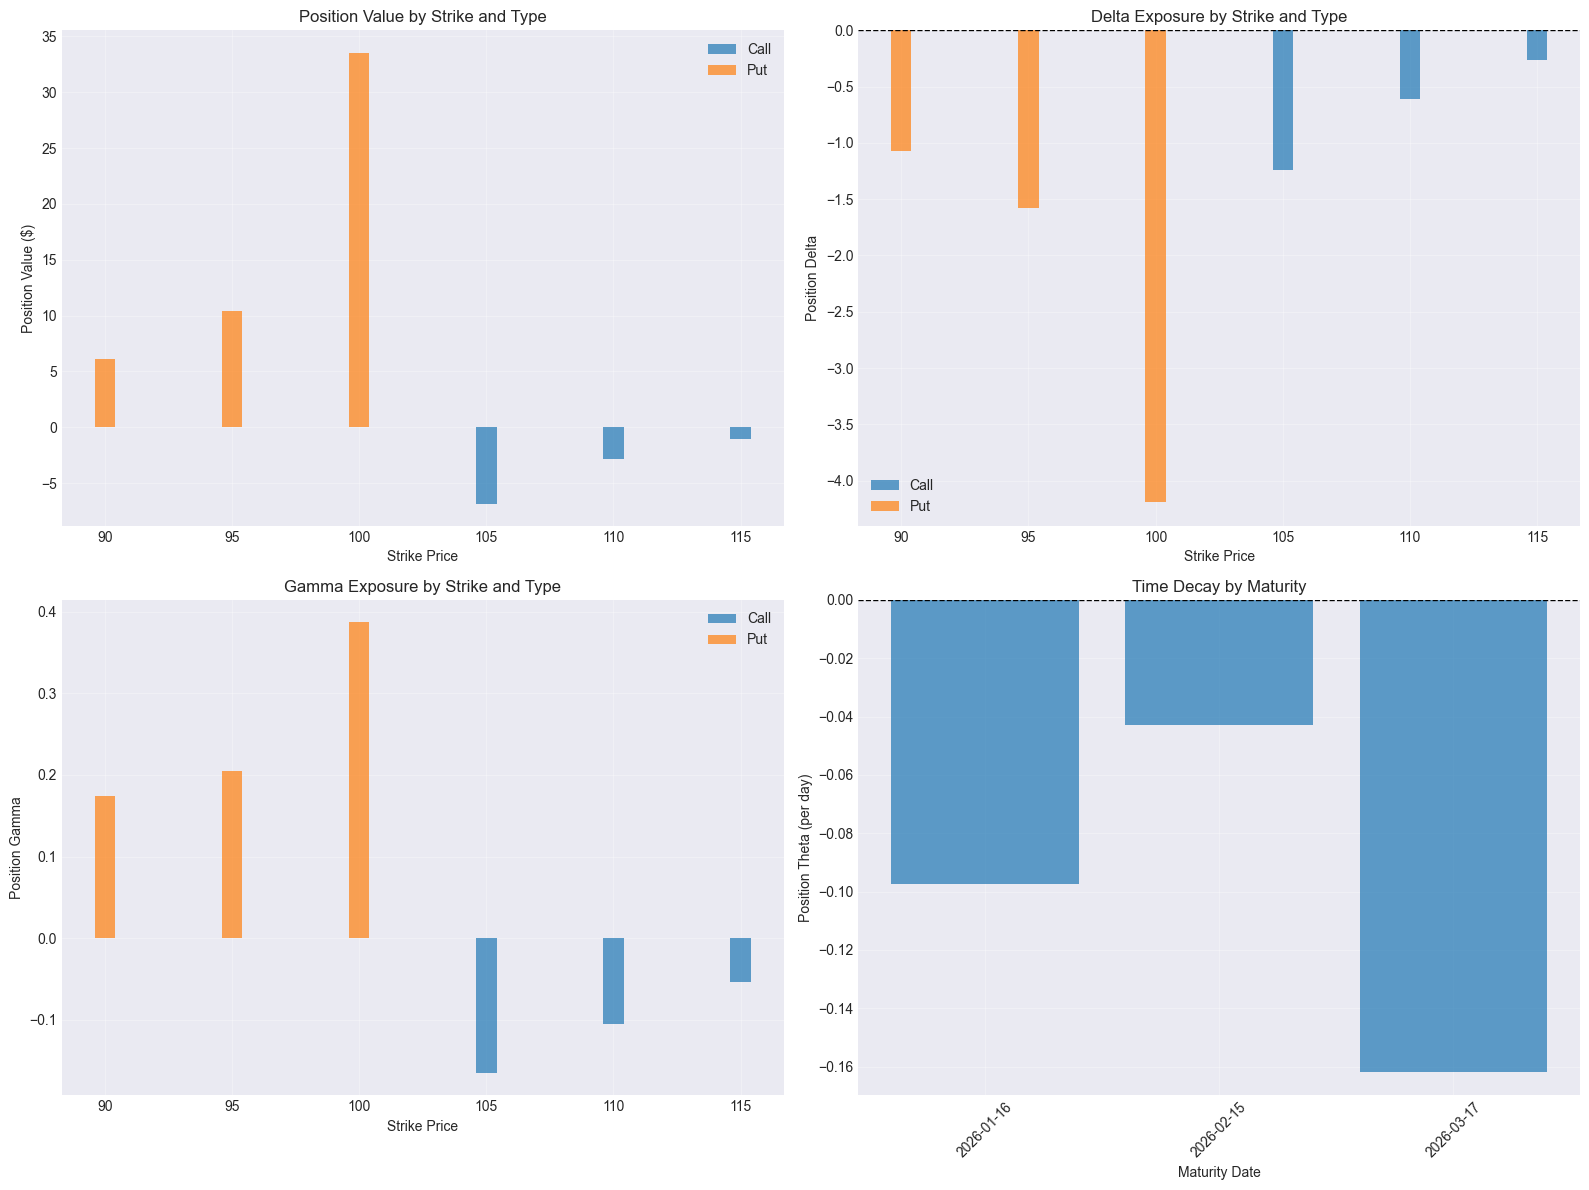

In [7]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Position Value by Strike
df_summary = df_positions.groupby(['type', 'strike']).agg({
    'position_value': 'sum',
    'quantity': 'sum'
}).reset_index()

ax1 = axes[0, 0]
for opt_type in df_summary['type'].unique():
    df_type = df_summary[df_summary['type'] == opt_type]
    ax1.bar(df_type['strike'], df_type['position_value'], 
            alpha=0.7, label=opt_type.capitalize())
ax1.set_xlabel('Strike Price')
ax1.set_ylabel('Position Value ($)')
ax1.set_title('Position Value by Strike and Type')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Delta by Strike
df_delta = df_positions.groupby(['type', 'strike'])['position_delta'].sum().reset_index()

ax2 = axes[0, 1]
for opt_type in df_delta['type'].unique():
    df_type = df_delta[df_delta['type'] == opt_type]
    ax2.bar(df_type['strike'], df_type['position_delta'], 
            alpha=0.7, label=opt_type.capitalize())
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax2.set_xlabel('Strike Price')
ax2.set_ylabel('Position Delta')
ax2.set_title('Delta Exposure by Strike and Type')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Gamma by Strike
df_gamma = df_positions.groupby(['type', 'strike'])['position_gamma'].sum().reset_index()

ax3 = axes[1, 0]
for opt_type in df_gamma['type'].unique():
    df_type = df_gamma[df_gamma['type'] == opt_type]
    ax3.bar(df_type['strike'], df_type['position_gamma'], 
            alpha=0.7, label=opt_type.capitalize())
ax3.set_xlabel('Strike Price')
ax3.set_ylabel('Position Gamma')
ax3.set_title('Gamma Exposure by Strike and Type')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Theta by Maturity
df_theta = df_positions.groupby('maturity')['position_theta'].sum().reset_index()

ax4 = axes[1, 1]
ax4.bar(range(len(df_theta)), df_theta['position_theta'], alpha=0.7)
ax4.set_xticks(range(len(df_theta)))
ax4.set_xticklabels(df_theta['maturity'], rotation=45)
ax4.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax4.set_xlabel('Maturity Date')
ax4.set_ylabel('Position Theta (per day)')
ax4.set_title('Time Decay by Maturity')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Scenario Analysis

Analyze portfolio P&L across different spot price scenarios.

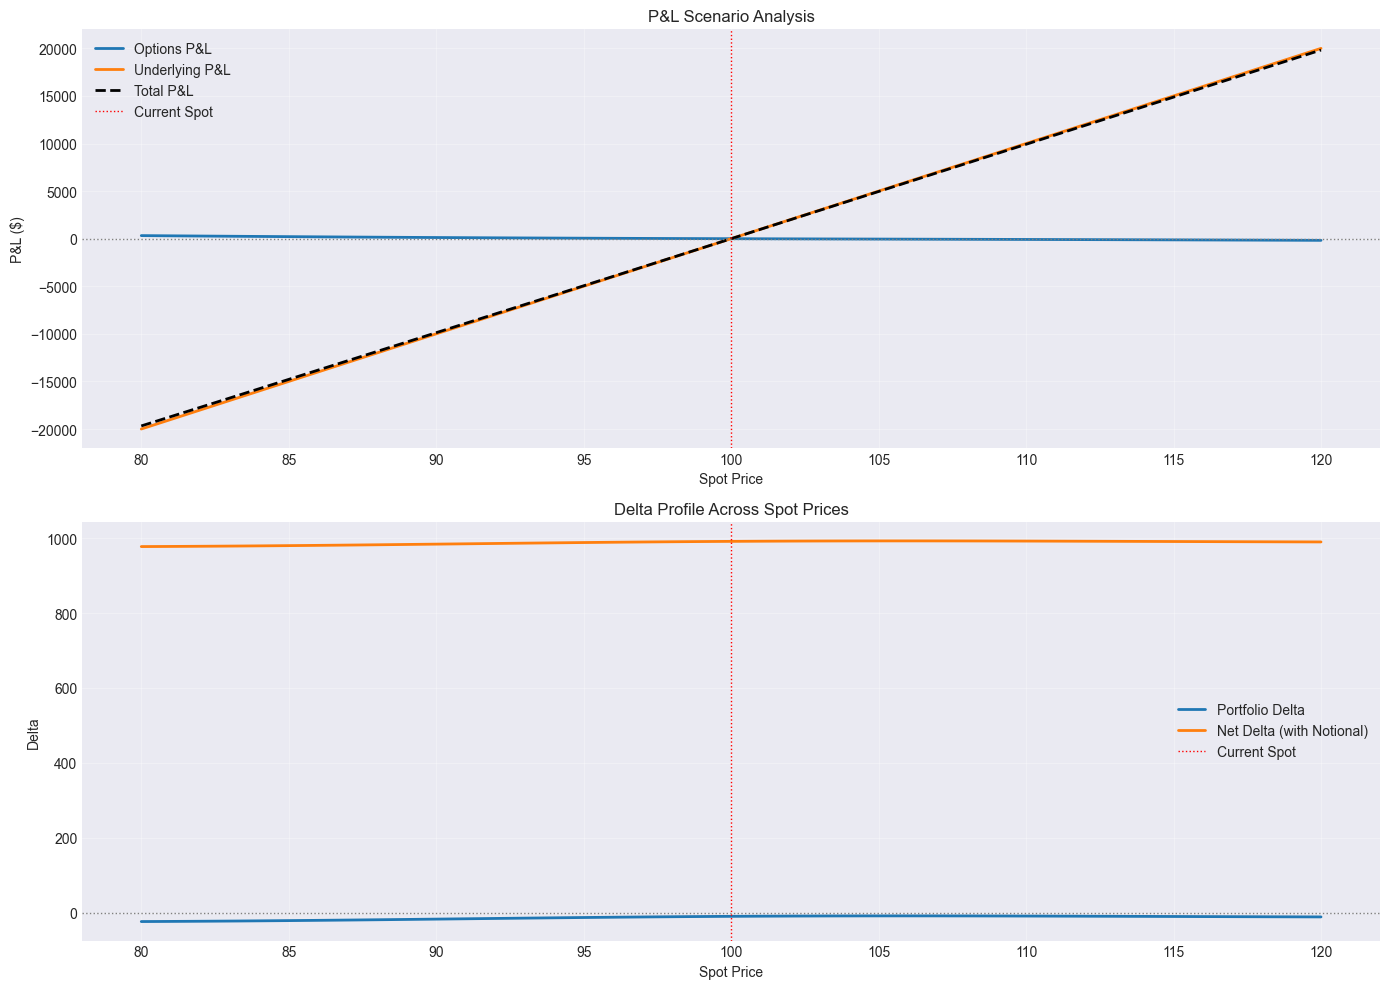


KEY SCENARIOS:

Spot = $89.80 (-10.2%):
  Options P&L: $+126.11
  Underlying P&L: $-10,204.08
  Total P&L: $-10,077.98
  Net Delta: 983.47

Spot = $99.59 (-0.4%):
  Options P&L: $+3.69
  Underlying P&L: $-408.16
  Total P&L: $-404.47
  Net Delta: 990.86

Spot = $110.20 (+10.2%):
  Options P&L: $-81.91
  Underlying P&L: $+10,204.08
  Total P&L: $+10,122.18
  Net Delta: 991.78


In [8]:
# Define spot price range for scenario analysis
spot_range = np.linspace(spot_price * 0.8, spot_price * 1.2, 50)

# Run scenario analysis
scenario_df = portfolio.scenario_analysis(spot_range)

# Calculate P&L from current position
current_value = portfolio.total_value()
scenario_df['portfolio_pnl'] = scenario_df['portfolio_value'] - current_value

# Calculate underlying P&L
scenario_df['underlying_pnl'] = (scenario_df['spot_price'] - spot_price) * notional_position

# Calculate total P&L
scenario_df['total_pnl'] = scenario_df['portfolio_pnl'] + scenario_df['underlying_pnl']

# Plot scenario analysis
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# P&L Breakdown
ax1 = axes[0]
ax1.plot(scenario_df['spot_price'], scenario_df['portfolio_pnl'], 
         label='Options P&L', linewidth=2)
ax1.plot(scenario_df['spot_price'], scenario_df['underlying_pnl'], 
         label='Underlying P&L', linewidth=2)
ax1.plot(scenario_df['spot_price'], scenario_df['total_pnl'], 
         label='Total P&L', linewidth=2, linestyle='--', color='black')
ax1.axhline(y=0, color='gray', linestyle=':', linewidth=1)
ax1.axvline(x=spot_price, color='red', linestyle=':', linewidth=1, label='Current Spot')
ax1.set_xlabel('Spot Price')
ax1.set_ylabel('P&L ($)')
ax1.set_title('P&L Scenario Analysis')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Delta Profile
ax2 = axes[1]
ax2.plot(scenario_df['spot_price'], scenario_df['total_delta'], 
         label='Portfolio Delta', linewidth=2)
ax2.plot(scenario_df['spot_price'], scenario_df['net_delta'], 
         label='Net Delta (with Notional)', linewidth=2)
ax2.axhline(y=0, color='gray', linestyle=':', linewidth=1)
ax2.axvline(x=spot_price, color='red', linestyle=':', linewidth=1, label='Current Spot')
ax2.set_xlabel('Spot Price')
ax2.set_ylabel('Delta')
ax2.set_title('Delta Profile Across Spot Prices')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print key scenarios
print("\nKEY SCENARIOS:")
print("=" * 60)
key_spots = [spot_price * 0.9, spot_price, spot_price * 1.1]
for key_spot in key_spots:
    idx = (np.abs(scenario_df['spot_price'] - key_spot)).argmin()
    row = scenario_df.iloc[idx]
    print(f"\nSpot = ${row['spot_price']:.2f} ({(row['spot_price']/spot_price-1)*100:+.1f}%):")
    print(f"  Options P&L: ${row['portfolio_pnl']:+,.2f}")
    print(f"  Underlying P&L: ${row['underlying_pnl']:+,.2f}")
    print(f"  Total P&L: ${row['total_pnl']:+,.2f}")
    print(f"  Net Delta: {row['net_delta']:.2f}")

## 7. Interactive Dashboard

Interactive widgets to explore different market scenarios.

In [9]:
# Create interactive widgets
spot_slider = widgets.FloatSlider(
    value=spot_price,
    min=spot_price * 0.5,
    max=spot_price * 1.5,
    step=0.5,
    description='Spot Price:',
    continuous_update=False
)

vol_slider = widgets.FloatSlider(
    value=volatility,
    min=0.1,
    max=0.5,
    step=0.01,
    description='Volatility:',
    continuous_update=False,
    readout_format='.2f'
)

output_widget = widgets.Output()

def update_dashboard(spot, vol):
    with output_widget:
        output_widget.clear_output(wait=True)
        
        # Update portfolio
        portfolio.update_market_conditions(spot_price=spot, volatility=vol)
        
        # Get updated stats
        stats = portfolio.summary_stats()
        
        # Display summary
        print("UPDATED PORTFOLIO METRICS")
        print("=" * 50)
        print(f"Spot Price: ${spot:.2f} ({(spot/spot_price-1)*100:+.1f}%)")
        print(f"Volatility: {vol:.2%}")
        print()
        print(f"Portfolio Value: ${stats['total_value']:,.2f}")
        print(f"Portfolio Delta: {stats['total_delta']:,.2f}")
        print(f"Net Delta: {stats['net_delta']:,.2f}")
        print(f"Hedge Ratio: {stats['hedge_ratio']:.2f}%")
        print(f"Total Gamma: {stats['total_gamma']:.4f}")
        print(f"Total Vega: {stats['total_vega']:.2f}")
        print(f"Total Theta: ${stats['total_theta']:.2f}/day")
        print("=" * 50)

# Link widgets to update function
interactive_plot = widgets.interactive(
    update_dashboard,
    spot=spot_slider,
    vol=vol_slider
)

display(interactive_plot)
display(output_widget)

interactive(children=(FloatSlider(value=100.0, continuous_update=False, description='Spot Price:', max=150.0, …

Output()

## 8. Hedge Adjustment Recommendations

Calculate and display recommended adjustments to improve the hedge.

In [10]:
# Reset to original market conditions
portfolio.update_market_conditions(
    spot_price=spot_price,
    volatility=volatility
)

stats = portfolio.summary_stats()

print("HEDGE ADJUSTMENT RECOMMENDATIONS")
print("=" * 70)
print(f"\nCurrent Net Delta: {stats['net_delta']:,.2f}")
print(f"Current Hedge Ratio: {stats['hedge_ratio']:.2f}%")

# Recommendation 1: Delta Neutral
print("\n1. TO ACHIEVE DELTA NEUTRALITY:")
delta_adj = stats['delta_adjustment']
if abs(delta_adj) < 1:
    print("   ✓ Portfolio is approximately delta neutral")
elif delta_adj > 0:
    print(f"   → BUY {delta_adj:.0f} shares of the underlying")
else:
    print(f"   → SELL {-delta_adj:.0f} shares of the underlying")

# Recommendation 2: Gamma exposure
print("\n2. GAMMA EXPOSURE:")
if stats['total_gamma'] > 0:
    print(f"   Current Gamma: {stats['total_gamma']:.4f} (POSITIVE)")
    print("   → Portfolio will become more long as spot increases")
    print("   → Portfolio will become more short as spot decreases")
else:
    print(f"   Current Gamma: {stats['total_gamma']:.4f} (NEGATIVE)")
    print("   → Portfolio will become more short as spot increases")
    print("   → Portfolio will become more long as spot decreases")

# Recommendation 3: Theta (time decay)
print("\n3. TIME DECAY (THETA):")
annual_theta = stats['total_theta'] * 365
if stats['total_theta'] < 0:
    print(f"   Daily Theta: ${stats['total_theta']:.2f}")
    print(f"   Annualized: ${annual_theta:.2f}")
    print("   → Portfolio loses value over time (typical for long options)")
    print("   → Consider rolling positions or reducing quantity")
else:
    print(f"   Daily Theta: ${stats['total_theta']:.2f}")
    print(f"   Annualized: ${annual_theta:.2f}")
    print("   → Portfolio gains value over time (typical for short options)")

# Recommendation 4: Vega exposure
print("\n4. VOLATILITY EXPOSURE (VEGA):")
print(f"   Total Vega: {stats['total_vega']:.2f}")
if stats['total_vega'] > 0:
    print("   → Portfolio benefits from volatility increase")
    print("   → Portfolio loses value if volatility decreases")
else:
    print("   → Portfolio benefits from volatility decrease")
    print("   → Portfolio loses value if volatility increases")

print("\n" + "=" * 70)

HEDGE ADJUSTMENT RECOMMENDATIONS

Current Net Delta: 991.05
Current Hedge Ratio: 0.90%

1. TO ACHIEVE DELTA NEUTRALITY:
   → SELL 991 shares of the underlying

2. GAMMA EXPOSURE:
   Current Gamma: 0.4421 (POSITIVE)
   → Portfolio will become more long as spot increases
   → Portfolio will become more short as spot decreases

3. TIME DECAY (THETA):
   Daily Theta: $-0.30
   Annualized: $-110.20
   → Portfolio loses value over time (typical for long options)
   → Consider rolling positions or reducing quantity

4. VOLATILITY EXPOSURE (VEGA):
   Total Vega: 1.92
   → Portfolio benefits from volatility increase
   → Portfolio loses value if volatility decreases



## 9. Export Results

Save portfolio positions and analysis to files.

In [11]:
# Export positions to CSV
positions_file = EXPORT_DIR / 'portfolio_positions.csv'
df_positions.to_csv(positions_file, index=False)
print(f"✓ Portfolio positions exported to '{positions_file}'")

# Export scenario analysis
scenario_file = EXPORT_DIR / 'scenario_analysis.csv'
scenario_df.to_csv(scenario_file, index=False)
print(f"✓ Scenario analysis exported to '{scenario_file}'")

# Create summary report
summary_file = EXPORT_DIR / 'portfolio_summary.txt'
with open(summary_file, 'w') as f:
    f.write("AMERICAN OPTIONS PORTFOLIO SUMMARY\n")
    f.write("=" * 70 + "\n\n")
    f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    
    f.write("MARKET PARAMETERS:\n")
    f.write(f"  Spot Price: ${spot_price}\n")
    f.write(f"  Volatility: {volatility*100}%\n")
    f.write(f"  Risk-Free Rate: {risk_free_rate*100}%\n")
    f.write(f"  Dividend Yield: {dividend_yield*100}%\n\n")
    
    f.write("PORTFOLIO METRICS:\n")
    for key, value in stats.items():
        f.write(f"  {key}: {value}\n")

print(f"✓ Portfolio summary exported to '{summary_file}'")
print(f"\nAll exports completed successfully to: {EXPORT_DIR.absolute()}")

✓ Portfolio positions exported to 'exports/portfolio_positions.csv'
✓ Scenario analysis exported to 'exports/scenario_analysis.csv'
✓ Portfolio summary exported to 'exports/portfolio_summary.txt'

All exports completed successfully to: /Users/tam/Repos/deltadewa/exports


## Next Steps

You can now:
- Modify the positions in Section 2 to reflect your actual portfolio
- Adjust market parameters in Section 1
- Use the interactive dashboard (Section 7) to explore different scenarios
- Review hedge recommendations (Section 8)
- Export your analysis (Section 9)

### Tips for Managing Your Portfolio:
1. **Delta Management**: Aim for net delta close to zero for a neutral hedge
2. **Gamma Monitoring**: Be aware of how your delta changes with spot price
3. **Theta Decay**: Factor in daily time decay when holding positions
4. **Vega Exposure**: Understand your volatility risk
5. **Rebalancing**: Regularly adjust positions as market moves and time passes